- This notebook is to testing Uncertainty sampling with feature selection

In [1]:
from utils import computeR2
from utils import computeR2_train
from utils import computeR2_train_self
from utils import computeR2_unlabel
from utils import getBatch
from utils import get_final_indices
from utils import feature_selection
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from utils import computeR2
from utils import computeR2_train
from utils import computeR2_train_self
from utils import computeR2_unlabel
from utils import getUcertainPoint
from utils import get_input_all
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [6]:
# Hyperparameters
numDataTotal = 509
labeledPoolN = 10
batchSz = 1
nAccs = (numDataTotal-labeledPoolN)//batchSz
RepeatTimes = 2
# Get the input files
myfile =r'Data/CombinedPSP.csv'
# X, y = get_input(myfile)
# If combine feature selection
X, y = get_input_all(myfile)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
X_test

,ABS_f_D,DISS_wf10_D,STAT_e,STAT_n_D,STAT_n_A,STAT_CC_D,STAT_CC_A,STAT_CC_D_An,STAT_CC_A_Ca,ABS_wf_D,...,CT_f_e_conn,CT_f_conn_D_An,CT_f_conn_A_Ca,CT_e_conn,CT_e_D_An,CT_e_A_Ca,CT_f_D_tort1,CT_f_A_tort1,CT_n_D_adj_An,CT_n_A_adj_Ca
1544,-1.708036,1.027544,0.657395,-1.708045,1.708045,1.253531,-0.724438,0.488924,-0.790924,-1.723597,...,-1.349026,-1.280313,0.521964,-1.026792,-0.901713,0.876105,1.093861,-0.172791,-0.911771,1.452069
6,1.428956,-0.867697,-0.741221,1.428959,-1.428959,-0.724733,0.852126,-0.167845,1.496796,1.538515,...,2.469796,1.462628,0.207815,1.231474,0.559623,-0.660088,-0.399208,0.095951,0.183462,-1.691755
251,1.122449,-1.122853,-0.958054,1.122453,-1.122453,-0.779685,0.589365,-0.167845,0.924866,1.322665,...,2.181712,2.020313,-0.849998,0.555835,0.436129,-1.009036,-0.321370,2.005515,0.416490,0.104716
838,0.225743,0.386133,0.188310,0.225749,-0.225749,0.044592,-0.461677,0.817309,-0.790924,0.256414,...,-0.636982,-0.786001,0.502134,-0.322234,-0.510651,0.335851,1.018732,-1.069470,2.001083,0.289647
310,1.169830,1.190566,1.183496,1.169833,-1.169833,0.044592,1.377647,1.145694,1.496796,1.164550,...,0.903061,0.372116,0.345114,3.016529,1.634307,1.144590,-1.625130,-1.341002,-0.538926,-0.529333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.526990,0.684492,0.539908,0.526990,-0.526990,0.099544,0.063844,0.488924,0.352936,0.546609,...,0.712634,0.224325,0.374869,1.786182,0.781616,0.633894,-1.006261,-0.892637,-0.119475,-0.925613
1566,-1.665938,0.259166,-0.079492,-1.665929,1.665929,0.209447,-0.724438,-0.496230,-0.790924,-1.708280,...,-1.166591,-1.158908,0.521964,-1.066226,-0.916414,0.124840,0.802961,0.134686,-1.680765,1.504907
993,0.092958,1.805784,2.221011,0.092969,-0.092969,1.858001,0.063844,1.802463,0.352936,0.064130,...,-1.051584,-1.027580,0.487004,0.140461,-0.206329,2.345793,-0.646004,-1.395740,-0.748651,-0.582170
315,1.167485,0.658837,0.534724,1.167493,-1.167493,-0.065312,0.852126,0.817309,1.496796,1.176713,...,0.853197,0.411866,0.270795,1.972837,1.063886,0.519768,-1.337568,-1.128893,0.486399,-0.185890


In [3]:
def UncertaintySampling_fs(X, y, labeledPoolN, runs=20, freq=10, fs_score=0.98, Alg='Uncertainty_fs'):
    R2Smooth = []
    MSEsmooth = []
    MAEsmooth = []
    Infosmooth = []
    R2_train = []
    R2_trainS = []
    SelectData = []
        
    for rt in tqdm(range(runs)):
        np.random.seed(rt) # set the same random choice for initial codition
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rt)
        dataPool = pd.concat([X_train, y_train], axis=1)
        # Reset the index to ensure the indices are continuous integers
        dataPool = dataPool.reset_index(drop=True)
        SelectIdx=np.random.choice(dataPool.shape[0], labeledPoolN, replace=False)
        dataPoolL = dataPool.iloc[SelectIdx, :]
        dataPool = dataPool.drop(SelectIdx)
        dataPool = dataPool.reset_index(drop=True)

        R2Res = np.empty((0,1), float)
        MSERes = np.empty((0,1), float)
        MAERes = np.empty((0,1), float)
        InfoRes = np.empty((0,1), float)
        R2Res_t = np.empty((0,1), float)
        R2Res_tS = np.empty((0,1), float)

        R2, Model, MSEstart,MAEstart = computeR2(dataPoolL, X_test, y_test, fs=True)
        R2Res = np.append(R2Res, R2, axis=0)
        MSERes = np.append(MSERes, MSEstart, axis=0)
        MAERes = np.append(MAERes, MAEstart, axis=0)
        Info = computeR2_unlabel(dataPool, dataPoolL, Model, fs=True)
        InfoRes = np.append(InfoRes, Info, axis=0)

        R2_t, Model, MSEstart_t,_ = computeR2_train(dataPoolL, X_train, y_train, fs=True)
        R2Res_t = np.append(R2Res_t, R2_t, axis=0)

        R2_tS, ModelS, MSEstart_tS,_ = computeR2_train_self(dataPoolL, fs=True)
        R2Res_tS = np.append(R2Res_tS, R2_tS, axis=0)

        # feature selection
        indices = feature_selection(dataPoolL.iloc[:, 0:-1],dataPoolL.iloc[:, -1], fs_score, 0, Alg)
        dataPoolL_fs = pd.concat([dataPoolL.iloc[:, 0:-1].iloc[:, indices],dataPoolL.iloc[:, -1]],axis=1)
        dataPool_fs = pd.concat([dataPool.iloc[:, 0:-1].iloc[:, indices], dataPool.iloc[:, -1]],axis=1)

        # get model with fewer features
        _, Model_fs, _, _ = computeR2(dataPoolL_fs, X_test.iloc[:, indices], y_test, fs=True)

        for i in range(499):
            print(f"Iteration: {i}")
            # print(f"DataPool shape before getBatch(): {dataPool.shape}")
            dataPool_fs = dataPool_fs.reset_index(drop=True)
            dataPointUncertain_fs, dataPool_fs, Idx = getUcertainPoint(dataPool_fs, Model_fs, fs=True)
            # print(f"DataPool shape after getBatch(): {dataPool.shape}")
            # dataPoolL = np.vstack((dataPoolL, dataBatch))
            dataPoolL_fs = pd.concat([dataPoolL_fs, dataPointUncertain_fs], axis=0, ignore_index=True)

            # Recover features
            dataPool = dataPool.reset_index(drop=True)
            dataBatch = dataPool.loc[Idx]
            dataPool = dataPool.drop(Idx)
            dataPoolL = pd.concat([dataPoolL, dataBatch], axis=0, ignore_index=True)
            

            cR2, Model, cMSE, cMAE = computeR2(dataPoolL, X_test, y_test, fs=True)
            cR2_t, Model_t, cMSEstart_t,_ = computeR2_train(dataPoolL, X_train, y_train, fs=True)
            cR2_tS, Model_tS, cMSEstart_tS,_ = computeR2_train_self(dataPoolL, fs=True)
            cInfo = computeR2_unlabel(dataPool, dataPoolL, Model, fs=True)

            R2Res = np.append(R2Res, cR2, axis=0)
            MSERes = np.append(MSERes, cMSE, axis=0)
            MAERes = np.append(MAERes, cMAE, axis=0)
            InfoRes = np.append(InfoRes, cInfo, axis=0)
            R2Res_t = np.append(R2Res_t, cR2_t, axis=0)
            R2Res_tS = np.append(R2Res_tS, cR2_tS, axis=0)

            if i % freq ==0:
                indices = feature_selection(dataPoolL.iloc[:, 0:-1],dataPoolL.iloc[:, -1], fs_score, i, Alg)
                dataPoolL_fs = pd.concat([dataPoolL.iloc[:, 0:-1].iloc[:, indices],dataPoolL.iloc[:, -1]],axis=1)
                dataPool_fs = pd.concat([dataPool.iloc[:, 0:-1].iloc[:, indices], dataPool.iloc[:, -1]],axis=1)

                # get model with fewer features
                _, Model_fs, _,_ = computeR2(dataPoolL_fs, X_test.iloc[:, indices], y_test, fs=True)

                cR2, Model, cMSE, cMAE = computeR2(dataPoolL, X_test, y_test, fs=True)
                cR2_t, Model_t, cMSEstart_t,_ = computeR2_train(dataPoolL, X_train, y_train, fs=True)
                cR2_tS, Model_tS, cMSEstart_tS,_ = computeR2_train_self(dataPoolL, fs=True)
                cInfo = computeR2_unlabel(dataPool, dataPoolL, Model, fs=True)
                
                # cR2, Model, cMSE, cMAE = computeR2(dataPoolL_fs, X_test.iloc[:,indices], y_test, fs=True)
                # cR2_t, Model_t, cMSEstart_t,_ = computeR2_train(dataPoolL_fs, X_train.iloc[:,indices], y_train, fs=True)
                # cR2_tS, Model_tS, cMSEstart_tS,_ = computeR2_train_self(dataPoolL_fs, fs=True)
                # cInfo = computeR2_unlabel(dataPool_fs, dataPoolL_fs, Model, fs=True)
            
                R2Res = np.append(R2Res, cR2, axis=0)
                MSERes = np.append(MSERes, cMSE, axis=0)
                MAERes = np.append(MAERes, cMAE, axis=0)
                InfoRes = np.append(InfoRes, cInfo, axis=0)
                R2Res_t = np.append(R2Res_t, cR2_t, axis=0)
                R2Res_tS = np.append(R2Res_tS, cR2_tS, axis=0)
      
        R2Smooth.append(R2Res)
        MSEsmooth.append(MSERes)
        MAEsmooth.append(MAERes)
        Infosmooth.append(InfoRes)
        R2_train.append(R2Res_t)
        R2_trainS.append(R2Res_tS)
        SelectData.append(dataPoolL)

    R2Smooth = np.asarray(R2Smooth)
    MSEsmooth = np.asarray(MSEsmooth)
    MAEsmooth = np.asarray(MAEsmooth)
    InfoSmooth = np.asarray(Infosmooth)
    R2_train = np.asarray(R2_train) 
    R2_trainS = np.asarray(R2_trainS)

    R2Smooth_std = np.std(R2Smooth, axis=0)#note variable update
    accuracySmooth = np.mean(R2Smooth, axis=0)
    
    InfoSmooth_std = np.std(InfoSmooth, axis=0)
    InfoSmooth_mean = np.mean(InfoSmooth, axis=0)
    # for train set
    R2_train_std = np.std(R2_train, axis=0)
    R2_train_mean = np.mean(R2_train, axis=0)
    # FOR TRAIN ITSELF
    R2_train_stdS = np.std(R2_trainS, axis=0)
    R2_train_meanS = np.mean(R2_trainS, axis=0)

    MSEsmooth_std = np.std(MSEsmooth, axis=0)
    MSEsmooth = np.mean(MSEsmooth, axis=0)
    
    MAEsmooth_std = np.std(MAEsmooth, axis=0)
    MAEsmooth = np.mean(MAEsmooth, axis=0)

    return (R2Smooth_std, accuracySmooth, InfoSmooth_std, InfoSmooth_mean,\
            MSEsmooth_std,MSEsmooth,MAEsmooth_std, MAEsmooth,\
            R2_train_std, R2_train_mean, R2_train_stdS, R2_train_meanS, SelectData)

In [3]:
# load pkl files

In [11]:
import pickle
# Specify the file path of your .pkl file
file_path = '/Users/haoliu/Documents/GitHub/Active-Learning-Using-various-representations/Results_Data/Uncertainty_fs_results_data_2023-12-26_12-35-59.pkl'

# Load the .pkl file
with open(file_path, 'rb') as file:
    load_data = pickle.load(file)

In [ ]:
def load_pickle_data(file_path):
    # Load the .pkl file
    with open(file_path, 'rb') as file:
        load_data = pickle.load(file)

    return load_data

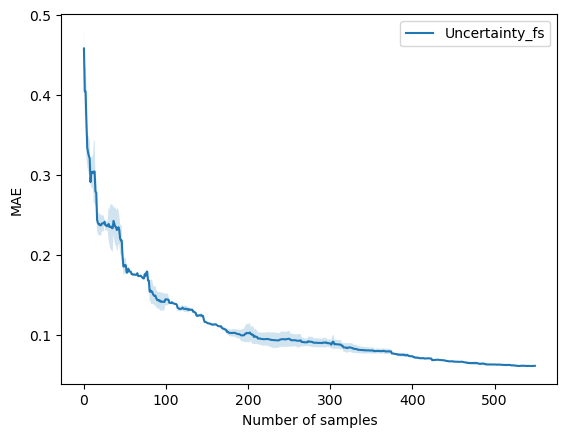

In [15]:
value, variance, Alg = load_data['MAEsmooth1'], load_data['MAEsmooth_std1'], 'Uncertainty_fs'
x_values = np.arange(len(value))

plt.plot(x_values, value, label=Alg)
plt.fill_between(x_values, (value+variance).flatten(), (value-variance).flatten(), alpha=0.2)
plt.xlabel('Number of samples')
plt.ylabel('MAE')
plt.legend()
# plt.savefig('Results_Plot/'+f'PerformancePlot_{Alg}_{formatted_datetime}.png')

In [14]:
load_data['MAEsmooth1'].shape

(550, 1)

In [16]:
pwd

'/Users/haoliu/Documents/GitHub/Active-Learning-Using-various-representations'